Here we extract the subset of the whole dataset. We run over several hyperparameters: 
1. the amount of genes to consider for scVelo
2. mixing the pseudotime kernel with the Velocity kernel ratio


we run the main cell developement line idenfied in chan et al (https://doi.org/10.1101/2023.07.31.551262) using the velocity


In [80]:
import pandas as pd ## importsb
import seaborn as sns
import numpy as np
import glob
import os
import random
import scipy
import matplotlib.pyplot as plt
import scvelo as scv
import networkx as nx
import anndata as ad
import cellrank as cr
import scanpy as sc
import networkx as nx

import os


In [118]:
path_main = "../"
path_plot = path_main + '/plots/'
# Check if path exists or not
isExist = os.path.exists(path_plot)
#printing if the path exists or not
print(isExist)

if not isExist:
       os.makedirs(path_plot) ##make the path where to save plots
       print(path_plot)




False
../../labelled/all_info/../plots/


## 1. load in the datasets take the subsets

In [119]:
wt_all =scv.read(path_main + 'data/chan_wt_dynamical_trimmed_with_PAX6.h5ad') ##replace with wt all genes path 
mut_all =scv.read(path_main + 'data/chan_mut_dynamical_trimmed_with_PAX6.h5ad') ##replace with mut all genes path 

pathway1_cells = ['RGP1','RGP2','RGP3','IN1','IP','EN','DLN','SLN','IN Progenitor'] #set the clusters included in the analysis

wt_path1 = wt_all[wt_all.obs.cluster.isin(pathway1_cells)]
mut_path1 = mut_all[mut_all.obs.cluster.isin(pathway1_cells)]


subset_names = ['wt','mut']
subsets = [wt_path1,mut_path1]
datasets = dict(zip(subset_names, subsets))
#mut_all = scv.read('../../labelled/all_info/chan_wt.h5ad')



/Users/samuelheczko/scvelo/scvelo/plotting/scatter.py:655: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/Users/samuelheczko/scvelo/scvelo/plotting/scatter.py:655: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


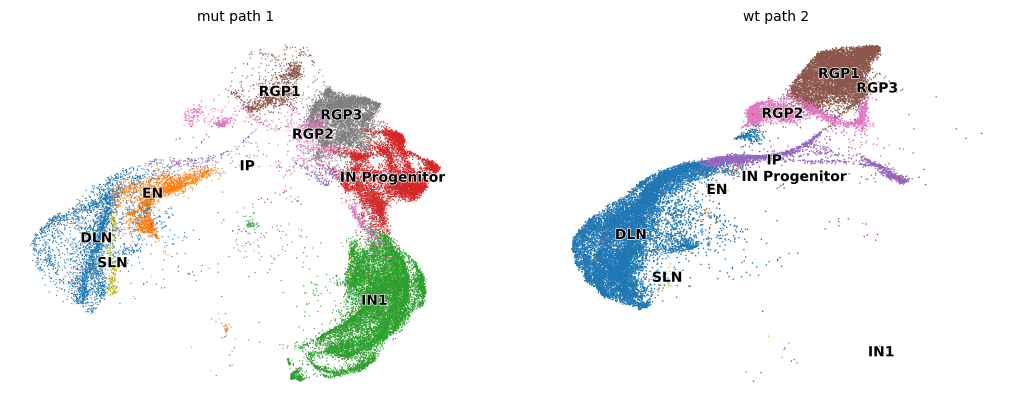

In [53]:
#mut_all[mut_all.obs.cluster.isin(pathway1_cells)] #subset the cells
##have a look at the clusters still included in the dataset

with scv.GridSpec(ncols=2) as pl: ##check the subsets
    pl.scatter(datasets['mut'], color='cluster', color_map='gnuplot',title='mut path 1')
    pl.scatter(datasets['wt'], color='cluster', color_map='gnuplot',title='wt path 2')
#pathway1_cells = ['RGP1','RGP2','RGP3','IN Progenitor','IN1','IP','EN','DLN','SLN']



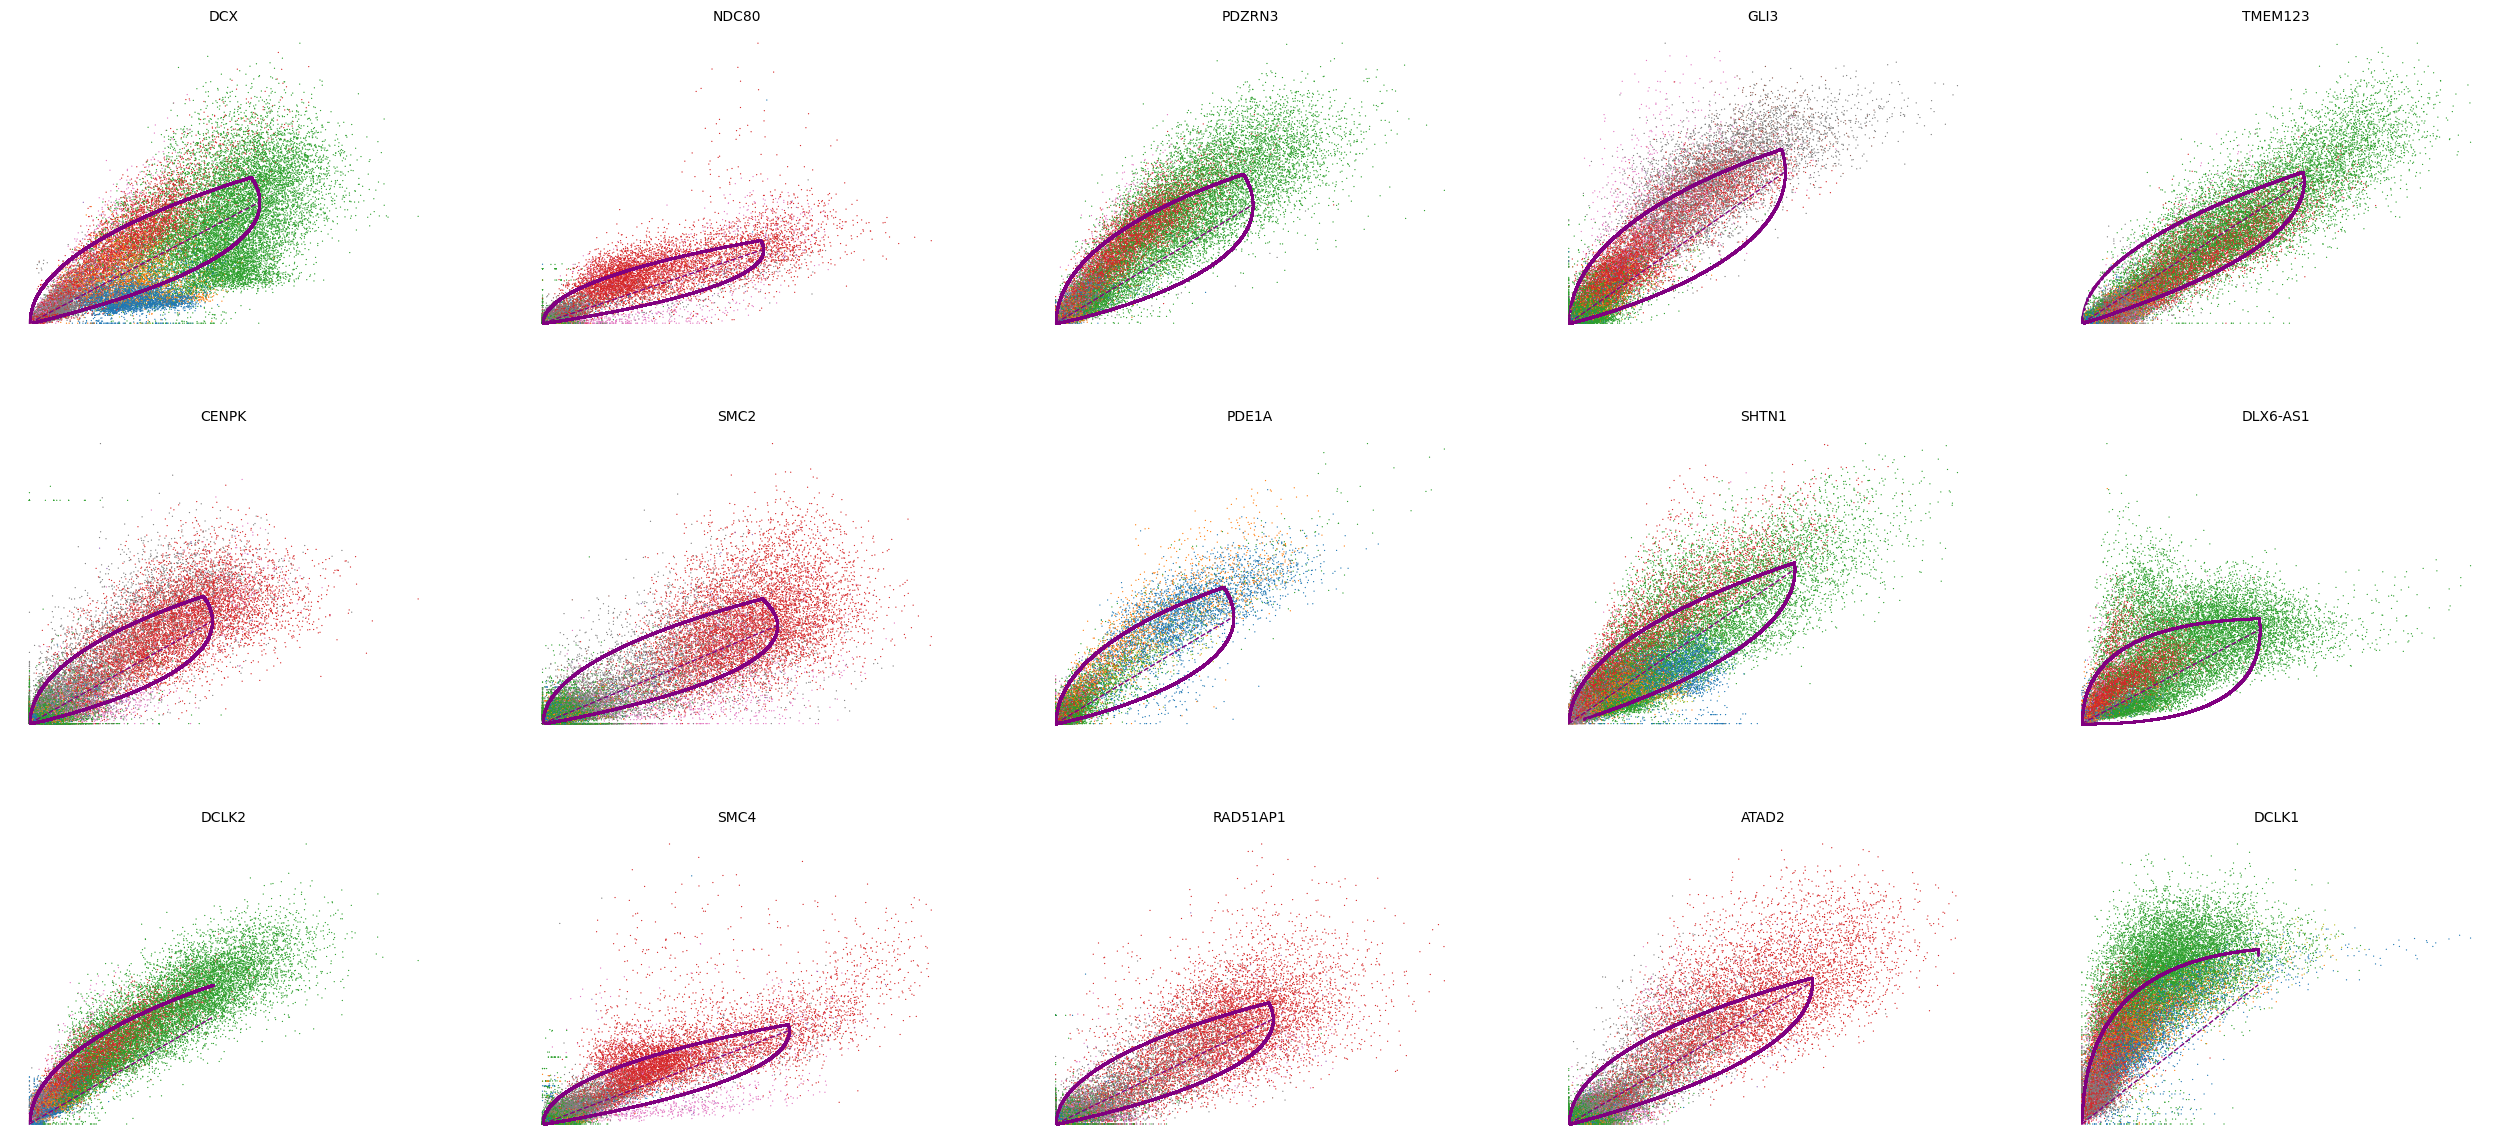

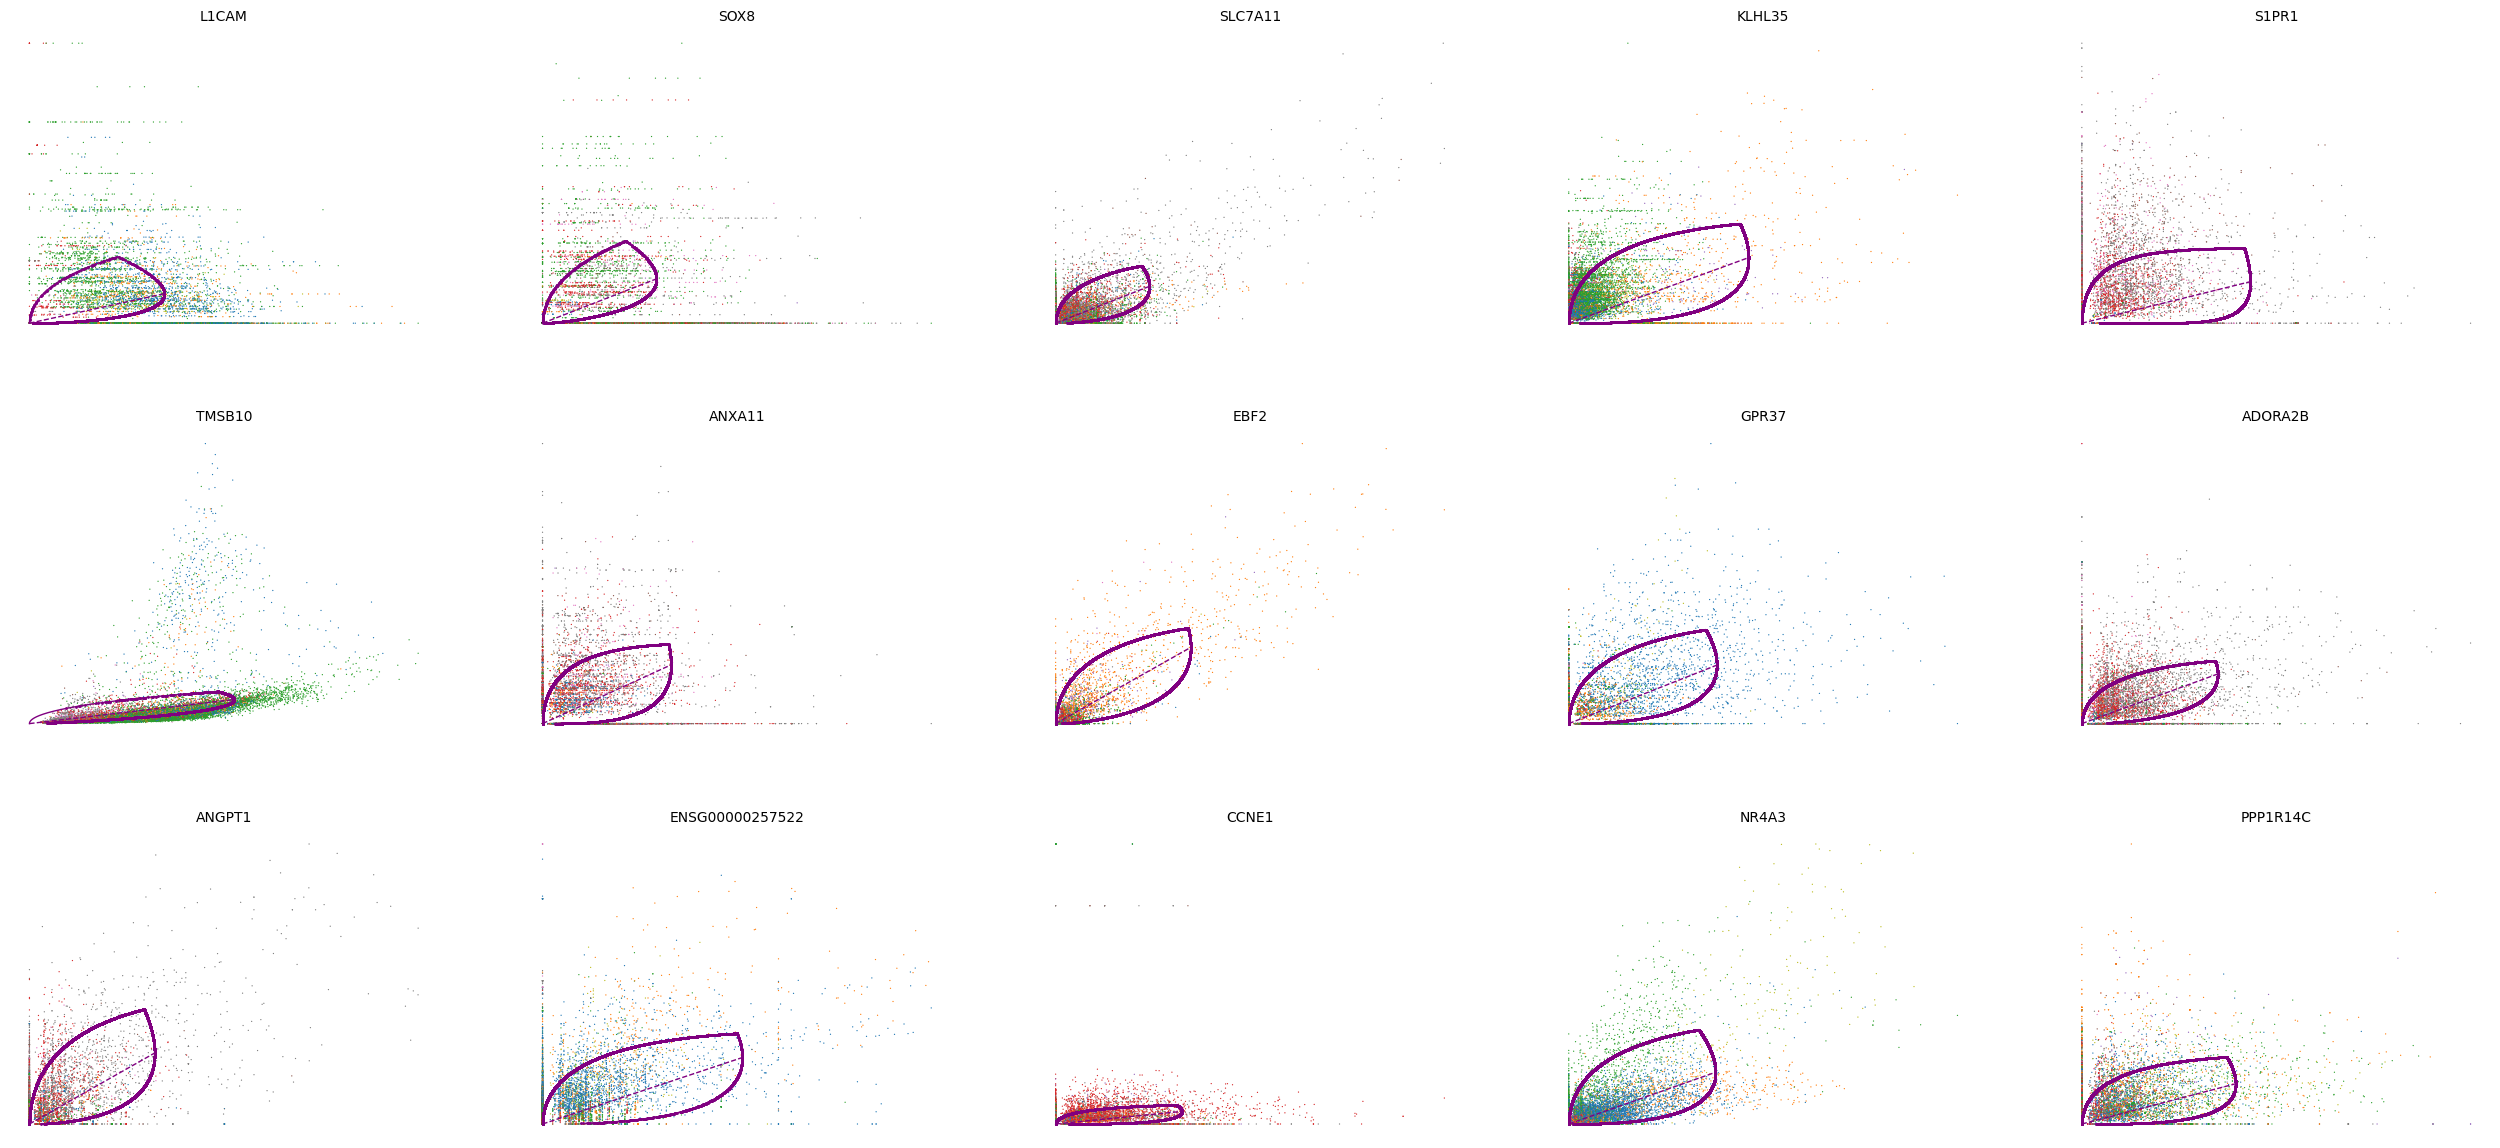

In [108]:
##dont run

top_genes = datasets['mut'].var['fit_likelihood'].sort_values(ascending=False).index
scv.pl.scatter(datasets['mut'], basis=top_genes[:15], color = 'cluster',ncols=5, frameon=False)




scv.pl.scatter(datasets['mut'], basis=top_genes[:15], color = 'cluster',ncols=5, frameon=False)



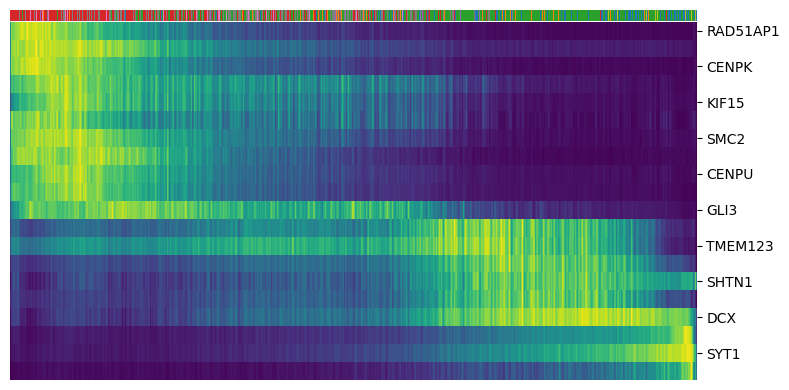

In [112]:
##dont run

top_genes = datasets['mut'].var['fit_likelihood'].sort_values(ascending=False).index[:20]
scv.pl.heatmap(datasets['mut'], var_names=top_genes, sortby='latent_time', col_color='cluster', n_convolve=100)

## 2. calcualte the dynamics of the subset

Here we find the driver genes using sc velo only and save the figures. (use these figures to analyse kinetics of the highest likelihood genes - can we see various kinetics)

In the future it might be useful to subset the DLN track of the mutant - compare the gene expression across the latent time

In [109]:
#gene_ns = np.geomspace(start = 100,stop = 5000, num = 10).astype(int)
#kernels = datas


gene_ns = np.array([500,1000,2000])

for mut_wt in datasets:
    dataset = datasets[mut_wt]
    for gene_n in gene_ns:
        scv.pp.filter_and_normalize(
        dataset, min_shared_counts=20, n_top_genes=gene_ns, subset_highly_variable=False) ##filter and normalise - change the amount of top varialbe genes considered for the velocity
        scv.pp.moments(dataset, n_pcs=20, n_neighbors=20) ##calcualte the moments
        scv.tl.recover_dynamics(dataset, n_jobs=-1) ##recover dynamics
        scv.tl.velocity(dataset, mode='dynamical', n_jobs=-1) #add the velocity vector based on the dynamics given earlier 
        scv.tl.velocity_graph(dataset,n_jobs=-1) #add a graph based off the velocity and nearest neighbour angle (cosine correlations (adata.uns)) - no each nearest neighbour has a transition probobablity based off the angle -- we have a weighted graph
        scv.tl.latent_time(dataset) ##calucate the the latent for each gene and take the largest peak --- cell latent time

        ##pseudotime

        if mut_wt == 'wt':
            dataset.uns["iroot"] = 200
        else:
            dataset.uns["iroot"] = 5000

        sc.tl.dpt(dataset) ##calcuate the pseudotime starting from the root cell
        sc.pl.embedding(
        dataset,
        color=["dpt_pseudotime"],
        color_map="gnuplot2",
        save = path_plot + f'{mut_wt}_pseudotime'
        )

        scv.pl.scatter(dataset, color='latent_time', color_map='gnuplot', size=80,save = path_plot + f'{mut_wt}_latent_time_n_genes_{gene_n}')
        scv.pl.scatter(dataset, color='velocity_pseudotime', color_map='gnuplot', size=80,save = path_plot + f'{mut_wt}_velocity_pseudotime_n_genes_{gene_n}')

        top_genes = dataset.var['fit_likelihood'].sort_values(ascending=False).index[:20] #check to top 20 most likely genes 
        scv.pl.heatmap(dataset, var_names=top_genes, sortby='latent_time', col_color='cluster', n_convolve=100,save = path_plot + f'{mut_wt}_heatmap_top_20_likelihood_heatmap_n_genes_{gene_n}') ## find the time periond they are expressed and plot the results
        scv.pl.scatter(dataset, basis=top_genes, color = 'cluster',ncols=5, frameon=False, save = path_plot + f'{mut_wt}_top_20_likelihood_plots_n_genes_{gene_n}') ## the top driver genes plots
        print(top_genes)





KeyboardInterrupt: 

## 3. use cell rank to calculate cell fates and so on

since the last round we ran with 2000 top genes -- that is the data we are working here with now

We build uo the 'kernels' (transiotion matrices) from the latent time (velocity katent time/pseudotime) and velocity we calcaulted earlier. 


In [64]:
for mut_wt in datasets:
    ##find the connectivyt graph (once again - done in scvleo before)


    print(mut_wt)
    dataset = datasets[mut_wt]

    vk = cr.kernels.VelocityKernel(adata)
    vk.compute_transition_matrix()

    ck = cr.kernels.ConnectivityKernel(adata)
    ck.compute_transition_matrix()

    combined_kernel = 0.8 * vk + 0.2 * ck

    combined_kernel.plot_projection()

    plot_random_walks(start_ixs={"cluster": "RGP1"}, max_iter=100, seed=0,save = path_plot + f'{mut_wt}_random_walks_100_steps_')

    ##pseudotime


    pk = cr.kernels.PseudotimeKernel(dataset, time_key="dpt_pseudotime")
    pk.compute_transition_matrix()

    pk.plot_projection(recompute=True,save = path_plot + f'{mut_wt}_pseudotime')

    #plots only the peseudotime with streamlines

    

    ##estimate the end and starting points
    estimator =  cr.estimators.GPCCA(combined_kernel) ##use the combined kernel to compute the macrostates

    estimator.fit(cluster_key="cluster", n_states= [4,8])
    estimator.plot_macrostates(which="all", discrete=False, legend_loc="right")

    estimator.plot_macrostates(which="all", discrete=False, legend_loc="right") ##plot the results

    estimator.predict_terminal_states(allow_overlap=True)
    estimator.predict_initial_states(allow_overlap=True)

    estimator.plot_macrostates(which="initial", discrete=False,legend_loc="right" ,save = path_plot + f'{mut_wt}_initial_states_auto') ##plot initial
    estimator.plot_macrostates(which="terminal",discrete=False, legend_loc="right",save = path_plot + f'{mut_wt}_terminal_states_auto') )


    estimator.compute_fate_probabilities()

    estimator.plot_fate_probabilities(same_plot=False,dpi = 300,save = path_plot + f'{mut_wt}_cell_fates_combined_kernel')


    estimatorPK =  cr.estimators.GPCCA(pk) ##use the pesudotime kernel to compute the macrostates

    estimatorPK.fit(cluster_key="cluster", n_states= [4,8])
    estimatorPK.plot_macrostates(which="all", discrete=False, legend_loc="right")

    estimatorPK.plot_macrostates(which="all", discrete=False, legend_loc="right") ##plot the results

    estimatorPK.predict_terminal_states(allow_overlap=True)
    estimatorPK.predict_initial_states(allow_overlap=True)

    estimatorPK.plot_macrostates(which="initial", discrete=False,legend_loc="right" ,save = path_plot + f'{mut_wt}_pseudotime_initial_states_auto') ##plot initial
    estimatorPK.plot_macrostates(which="terminal",discrete=False, legend_loc="right",save = path_plot + f'{mut_wt}_Pseudotime_terminal_states_auto') )


    estimatorPK.compute_fate_probabilities()

    estimatorPK.plot_fate_probabilities(same_plot=False,dpi = 300,save = path_plot + f'{mut_wt}_cell_fates_pseudotime_kernel')

    dataset.write(path_main + f'notebooks/{mut_wt}_all_genes_pseudotime_velocity_latent_times.h5ad'compression="gzip")


    
    











<35960x35960 sparse matrix of type '<class 'numpy.float32'>'
	with 5350538 stored elements in Compressed Sparse Row format>

View of AnnData object with n_obs × n_vars = 24595 × 1936
    obs: 'Clusters', '_X', '_Y', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'cluster'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'log1p', 'neighbors', 'pca', 'recover_dynamics', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs', 'loss'
    layers: 'Ms', 'Mu', 'ambiguous', 'fit_t', 'fit_tau', 'fit_tau_', 'matrix', 'spliced', 'unspliced', 'velocity', 'velocity_u'
    obsp: 'connectivities', 'distances'

## 3. build the kernels and transition probability graphs

## 4. calculate the driver genes for each cell fate

ran on python 3.11 with following packages
Package                 Version             Editable project location
----------------------- ------------------- --------------------------
absl-py                 2.0.0 \
aiohttp                 3.8.6 \
aiosignal               1.3.1 \
anndata                 0.10.2 \
annotated-types         0.6.0 \
anyio                   3.7.1 \
appnope                 0.1.2
array-api-compat        1.4
arrow                   1.3.0
asttokens               2.0.5
async-timeout           4.0.3
attrs                   23.1.0
backcall                0.2.0
backoff                 2.2.1
beautifulsoup4          4.12.2
blessed                 1.20.0
boltons                 23.0.0
boto3                   1.28.67
botocore                1.31.67
Brotli                  1.0.9
cellrank                2.0.1.dev7+gf3a6a0e
certifi                 2023.7.22
cffi                    1.15.1
chardet                 5.2.0
charset-normalizer      3.3.0
chex                    0.1.7
click                   8.1.7
comm                    0.1.2
conda                   23.9.0
conda-package-handling  2.2.0
conda_package_streaming 0.9.0
contextlib2             21.6.0
contourpy               1.1.1
cospar                  0.3.3
croniter                1.4.1
cryptography            41.0.3
cycler                  0.12.1
dateutils               0.6.12
debugpy                 1.6.7
decorator               5.1.1
deepdiff                6.6.1
dm-tree                 0.1.8
docrep                  0.3.2
ete3                    3.1.3
etils                   1.5.1
executing               0.8.3
fastapi                 0.104.0
fastcluster             1.2.6
filelock                3.12.4
flax                    0.7.4
fonttools               4.43.1
frozenlist              1.4.0
fsspec                  2023.9.2
gseapy                  1.0.6
h11                     0.14.0
h5py                    3.10.0
htmlmin                 0.1.12
idna                    3.4
igraph                  0.10.8
ImageHash               4.3.1
importlib-resources     6.1.0
inquirer                3.1.3
install                 1.3.5
ipykernel               6.25.2
ipython                 8.15.0
ipywidgets              8.1.1
itsdangerous            2.1.2
jax                     0.4.19
jaxlib                  0.4.19
jedi                    0.18.1
Jinja2                  3.0.3
jmespath                1.0.1
joblib                  1.1.1
jsonpatch               1.32
jsonpointer             2.1
jupyter_client          8.1.0
jupyter_core            5.3.0
jupyterlab-widgets      3.0.9
kiwisolver              1.4.5
leidenalg               0.10.1
lightning               2.0.9.post0
lightning-cloud         0.5.42
lightning-utilities     0.9.0
llvmlite                0.41.0
loompy                  3.0.7
markdown-it-py          3.0.0
MarkupSafe              2.1.3
matplotlib              3.7.0
matplotlib-inline       0.1.6
mdurl                   0.1.2
missingno               0.5.2
mizani                  0.9.3
ml-collections          0.1.1
ml-dtypes               0.3.1
mpmath                  1.3.0
msgpack                 1.0.7
mudata                  0.2.3
multidict               6.0.4
multimethod             1.10
multipledispatch        1.0.0
natsort                 8.4.0
nest-asyncio            1.5.6
networkx                3.1
numba                   0.58.1
numpy                   1.25.0
numpy-groupies          0.10.2
numpyro                 0.13.2
opt-einsum              3.3.0
optax                   0.1.7
orbax-checkpoint        0.4.1
ordered-set             4.1.0
packaging               23.1
pandas                  2.1.1
pandas-profiling        3.2.0
parso                   0.8.3
patsy                   0.5.3
petsc4py                3.19.0
pexpect                 4.8.0
phik                    0.12.3
pickleshare             0.7.5
Pillow                  10.1.0
pip                     23.3
platformdirs            3.10.0
plotnine                0.12.3
pluggy                  1.0.0
progressbar2            4.2.0
prompt-toolkit          3.0.36
protobuf                4.24.4
psutil                  5.9.0
ptyprocess              0.7.0
pure-eval               0.2.2
pycosat                 0.6.6
pycparser               2.21
pydantic                2.1.1
pydantic_core           2.4.0
pygam                   0.9.0
Pygments                2.15.1
pygpcca                 1.0.4
PyJWT                   2.8.0
pynndescent             0.5.10
pyOpenSSL               23.2.0
pyparsing               3.1.1
pyro-api                0.1.2
pyro-ppl                1.8.6
PySocks                 1.7.1
python-dateutil         2.8.2
python-editor           1.0.4
python-multipart        0.0.6
python-utils            3.8.1
pytorch-lightning       2.1.0
pytz                    2023.3.post1
PyWavelets              1.4.1
PyYAML                  6.0.1
pyzmq                   25.1.0
readchar                4.0.5
requests                2.31.0
rich                    13.6.0
ruamel.yaml             0.17.21
s3transfer              0.7.0
scanpy                  1.9.5
scikit-learn            1.1.3
scikit-misc             0.3.0
scipy                   1.11.3
scvelo                  0.3.0               /Users/samuelheczko/scvelo
scvi-tools              1.0.4
seaborn                 0.13.0
session-info            1.0.0
setuptools              68.0.0
six                     1.16.0
slepc4py                3.19.2
sniffio                 1.3.0
soupsieve               2.5
sparse                  0.14.0
stack-data              0.2.0
starlette               0.27.0
starsessions            1.3.0
statsmodels             0.14.0
stdlib-list             0.9.0
sympy                   1.12
tangled-up-in-unicode   0.2.0
tensorstore             0.1.46
texttable               1.7.0
threadpoolctl           3.2.0
toolz                   0.12.0
torch                   2.1.0
torchmetrics            1.2.0
tornado                 6.3.3
tqdm                    4.65.0
traitlets               5.7.1
truststore              0.8.0
types-python-dateutil   2.8.19.14
typing_extensions       4.8.0
tzdata                  2023.3
umap-learn              0.5.4
urllib3                 1.26.18
uvicorn                 0.23.2
visions                 0.7.4
wcwidth                 0.2.5
websocket-client        1.6.4
websockets              11.0.3
wheel                   0.41.2
widgetsnbextension      4.0.9
wrapt                   1.15.0
xarray                  2023.10.1
yarl                    1.9.2
zipp                    3.17.0
zstandard               0.19.0




it assumes following file structure

└── PAX6_code
│   └── data
│   └── notebooks
│   └── plots